# 2019 Dask User Survey Results

This notebook presents the results of the 2019 Dask User Survey,
which ran earlier this summer. Thanks to everyone who took the time to fill out the survey!
We had 259 responses.

These results help us better understand the Dask community and will guide future development efforts.

## Highlights

Overall, we found that the survey respondents really care about improved documentation, and ease of use (including ease of deployment), and scaling. While Dask brings together many different communities (big arrays versus big dataframes, traditional HPC users versus cloud-native resource managers), there was general agreement in what is most important for Dask.

In [26]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import re

# sns.set(style="ticks")

api_choices = ['Array', 'Bag', 'DataFrame', 'Delayed', 'Futures', 'ML', 'Xarray']
cluster_manager_choices = [
    "SSH",
    "Kubernetes",
    "HPC",
    "My workplace has a custom solution for this",
    "Hadoop / Yarn / EMR",
]

def shorten(label):
    return textwrap.shorten(label, 50)


def fmt_percent(ax):
    ticklabels = ['{:,.2f}%'.format(x) for x in ax.get_xticks()]
    ax.set_xticklabels(ticklabels)
    sns.despine()
    return ax


df = (
    pd.read_csv("data/results.csv", parse_dates=['Timestamp'])
      .replace({"How often do you use Dask?": "I use Dask all the time, even when I sleep"}, "Every day")
)
df.rename(columns=shorten).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 24 columns):
Timestamp                                             259 non-null datetime64[ns]
Dask APIs                                             256 non-null object
Interactive or Batch?                                 254 non-null object
Local machine or Cluster?                             255 non-null object
How often do you use Dask?                            258 non-null object
What Dask resources have you used for [...]           255 non-null object
Which would help you most right now?                  252 non-null object
Is Dask stable enough for you?                        253 non-null object
What common feature requests do you care [...]        256 non-null object
What common feature requests do you care [...]        243 non-null object
What common feature requests do you care [...]        245 non-null object
What common feature requests do you care [...]        240 non-null object

Each row of the DataFrame is a single response. Each column is some metadata (e.g. `Timestamp`) or a specific question.

## Results per day

The bulk of our responses came on the first day. After that, we had a handful of trickling in daily.

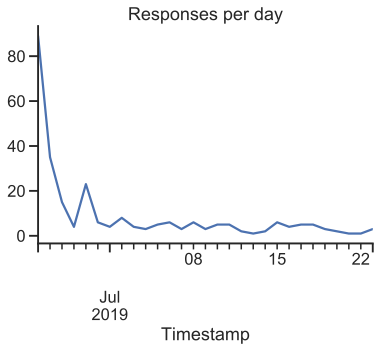

In [5]:
df.resample("D", on="Timestamp").Timestamp.count().plot(title='Responses per day')
sns.despine()

Overall, we had good response rates on each question. Most were skipped by fewer than 2% of the respondents.
Those with higher non-response rates (like "Preferred Cloud") aren't applicable to everyone.

In [25]:
df.isna().mean(0).rename(shorten)

Timestamp                                             0.000000
Dask APIs                                             0.011583
Interactive or Batch?                                 0.019305
Local machine or Cluster?                             0.015444
How often do you use Dask?                            0.003861
What Dask resources have you used for [...]           0.015444
Which would help you most right now?                  0.027027
Is Dask stable enough for you?                        0.023166
What common feature requests do you care [...]        0.011583
What common feature requests do you care [...]        0.061776
What common feature requests do you care [...]        0.054054
What common feature requests do you care [...]        0.073359
What common feature requests do you care [...]        0.054054
What common feature requests do you care [...]        0.046332
What common feature requests do you care [...]        0.057915
What common feature requests do you care [...]        0

Now we'll go through some individual items questions, highlighting particularly interesting results.

## How do you use Dask?

For learning resources, almost every respondent uses the documentation.

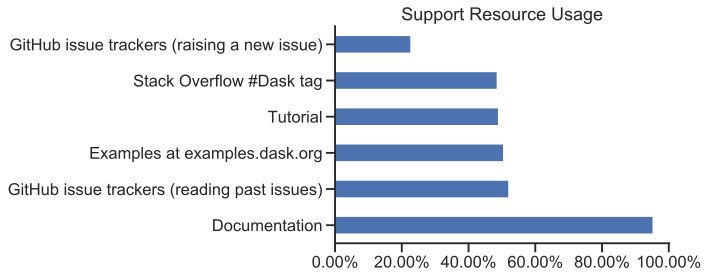

In [8]:
ax = (
    df['What Dask resources have you used for support in the last six months?']
    .str.split(";").explode()
    .value_counts().head(6)
    .div(len(df)).mul(100).plot.barh()
);
fmt_percent(ax).set(title="Support Resource Usage");

Most respondents use Dask at least occasionally. Fortunately we had a decent number of respondents who are just looking into Dask, yet still spent the time to take the survey.

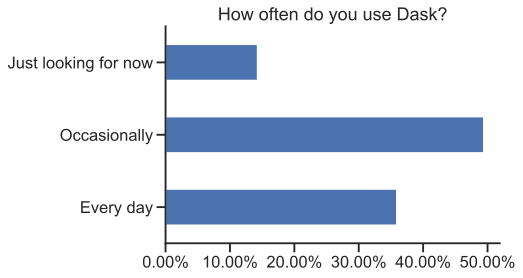

In [9]:
usage_order = [
    'Every day',
    'Occasionally',
    'Just looking for now',
]
ax = df['How often do you use Dask?'].value_counts().loc[usage_order].div(len(df)).mul(100).plot.barh()
fmt_percent(ax).set(title="How often do you use Dask?");

I'm curiuos about how learning resource usage changes as users become more experienced.

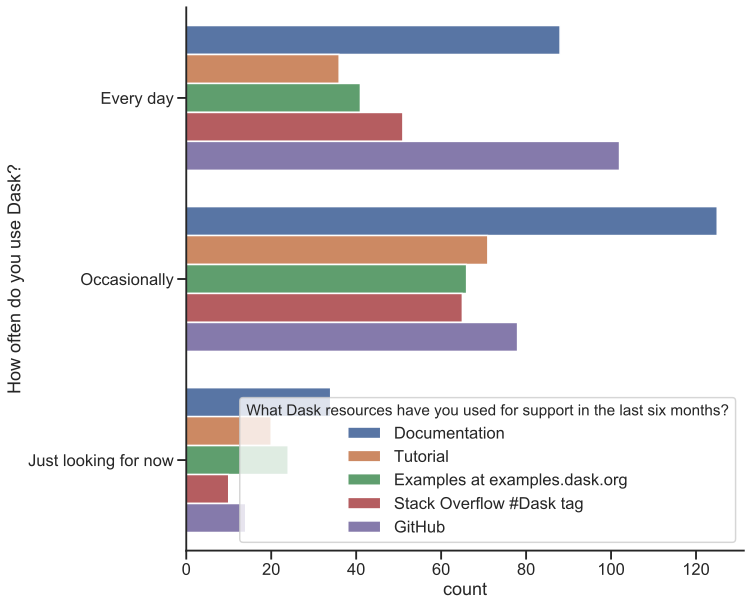

In [28]:
resources = df['What Dask resources have you used for support in the last six months?'].str.split(";").explode()
top = resources.value_counts().head(6).index
resources = resources[resources.isin(top)]

m = (
    pd.merge(df[['How often do you use Dask?']], resources, left_index=True, right_index=True)
      .replace(re.compile("GitHub.*"), "GitHub")
)

fig, ax = plt.subplots(figsize=(10, 10))

sns.countplot(hue="What Dask resources have you used for support in the last six months?",
              y='How often do you use Dask?',
              order=usage_order,
              data=m, ax=ax)
sns.despine()

Overall, documentation is still the leader across user user groups.

The usage of the [Dask tutorial](https://github.com/dask/dask-tutorial) and the [dask examples](examples.dask.org) are relatively consistent across groups. The primary difference between regular and new users is that regular users are more likely to engage on GitHub.

From StackOverflow questions and GitHub issues, we have a vague idea about which parts of the library are used.
The survey shows that (for our respondents at least) DataFrame and Delayed are the most commonly used APIs.

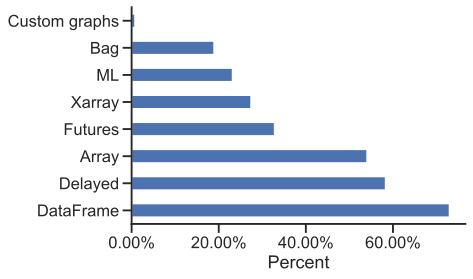

In [11]:
api_counts = (
    df['Dask APIs'].str.split(";").explode().value_counts()
    .div(len(df)).mul(100)
)
ax = api_counts.sort_values().nlargest(8).plot.barh()
fmt_percent(ax).set(xlabel="Percent")
sns.despine();

About 65% of our respondents are using Dask on a Cluster.

In [12]:
'{:0.2%}'.format(df['Local machine or Cluster?'].str.contains("Cluster").mean())

'65.49%'

But the majority of respondents *also* use Dask on their laptop.
This highlights the importance of Dask scaling down, either for
prototyping with a `LocalCluster`, or for out-of-core analysis
using `LocalCluster` or one of the single-machine schedulers.

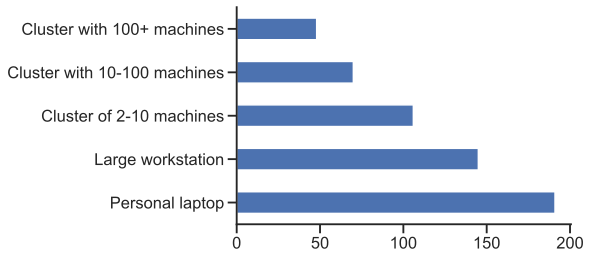

In [13]:
order = [
    'Personal laptop',
    'Large workstation',
    'Cluster of 2-10 machines',
    'Cluster with 10-100 machines',
    'Cluster with 100+ machines'
]
df['Local machine or Cluster?'].str.split(";").explode().value_counts().loc[order].plot.barh();
sns.despine()

Most respondents use Dask interactively, at least some of the time.

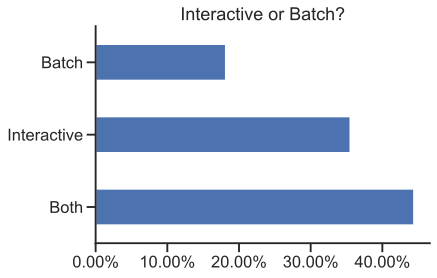

In [14]:
mapper = {
    "Interactive:  I use Dask with Jupyter or IPython when playing with data;Batch: I submit scripts that run in the future": "Both",
    "Interactive:  I use Dask with Jupyter or IPython when playing with data": "Interactive",
    "Batch: I submit scripts that run in the future": "Batch",
    
}

ax = df["Interactive or Batch?"].map(mapper).value_counts().div(len(df)).mul(100).plot.barh()
sns.despine()
fmt_percent(ax)
ax.set(title='Interactive or Batch?');

Most repondents thought that more documentation and examples would be the most valuable improvements to the project. This is especially pronounced among new users. But even among those using Dask everyday more people thought that "More examples" is more valuable than "New features" or "Performance improvements".

In [15]:
help_by_use = (
    df.groupby("How often do you use Dask?")['Which would help you most right now?']
    .value_counts()
    .unstack()
)

(
    help_by_use
        .style
        .background_gradient(axis="columns")
        .set_caption("Normalized by row. Darker means that a higher proporiton of "
                     "users with that usage frequency prefer that priority.")
)

Which would help you most right now?,Bug fixes,More documentation,More examples in my field,New features,Performance improvements
How often do you use Dask?,,,,,
Every day,9,11,25,22,23
Just looking for now,1,3,18,9,5
Occasionally,14,27,52,18,15


Perhaps users of certain dask APIs feel differenlty from the group as a whole? We perform a similar analysis grouped by API use, rather than frequency of use.

In [16]:
help_by_api = (
    pd.merge(
        df['Dask APIs'].str.split(';').explode(),
        df['Which would help you most right now?'],
        left_index=True, right_index=True)
    .groupby('Which would help you most right now?')['Dask APIs'].value_counts()
    .unstack(fill_value=0).T
    .loc[['Array', 'Bag', 'DataFrame', 'Delayed', 'Futures', 'ML', 'Xarray']]
    
)
(
    help_by_api
        .style
        .background_gradient(axis="columns")
        .set_caption("Normalized by row. Darker means that a higher proporiton of "
                     "users of that API prefer that priority.")
)

Which would help you most right now?,Bug fixes,More documentation,More examples in my field,New features,Performance improvements
Dask APIs,,,,,
Array,10,24,62,15,25
Bag,3,11,16,10,7
DataFrame,16,32,71,39,26
Delayed,16,22,55,26,27
Futures,12,9,25,20,17
ML,5,11,23,11,7
Xarray,8,11,34,7,9


Nothing really stands out. The "futures" users (who we expect to be relatively advanced) may prioritize features and performance over documentation. But everyone agrees that more examples are the highest priority.

## Common Feature Requests

For specific features, we made a list of things that we (as developers) thought might be important.

In [17]:
common = (df[df.columns[df.columns.str.startswith("What common feature")]]
          .rename(columns=lambda x: x.lstrip("What common feature requests do you care about most?[").rstrip(r"]")))
common.head()

,Better Numpy/Pandas support,Better Scikit-Learn/ML support,Integrate with Deep Learning Frameworks,Support for new libraries in my field,Improve Scaling,Dashboard / Diagnostics,Ease of deployment,Cloud integration,Managing many users,GPUs
0,Somewhat useful,Somewhat useful,Critical to me,Not relevant for me,Somewhat useful,Somewhat useful,Somewhat useful,Not relevant for me,Somewhat useful,Somewhat useful
1,Critical to me,Critical to me,Not relevant for me,Not relevant for me,Critical to me,Critical to me,Somewhat useful,Somewhat useful,Somewhat useful,Critical to me
2,Critical to me,Somewhat useful,Somewhat useful,Somewhat useful,Somewhat useful,Critical to me,Critical to me,Critical to me,Critical to me,Somewhat useful
3,Critical to me,Critical to me,Somewhat useful,Critical to me,Somewhat useful,Somewhat useful,Somewhat useful,Somewhat useful,Somewhat useful,Somewhat useful
4,Somewhat useful,NaN,NaN,Somewhat useful,NaN,NaN,Somewhat useful,NaN,NaN,NaN


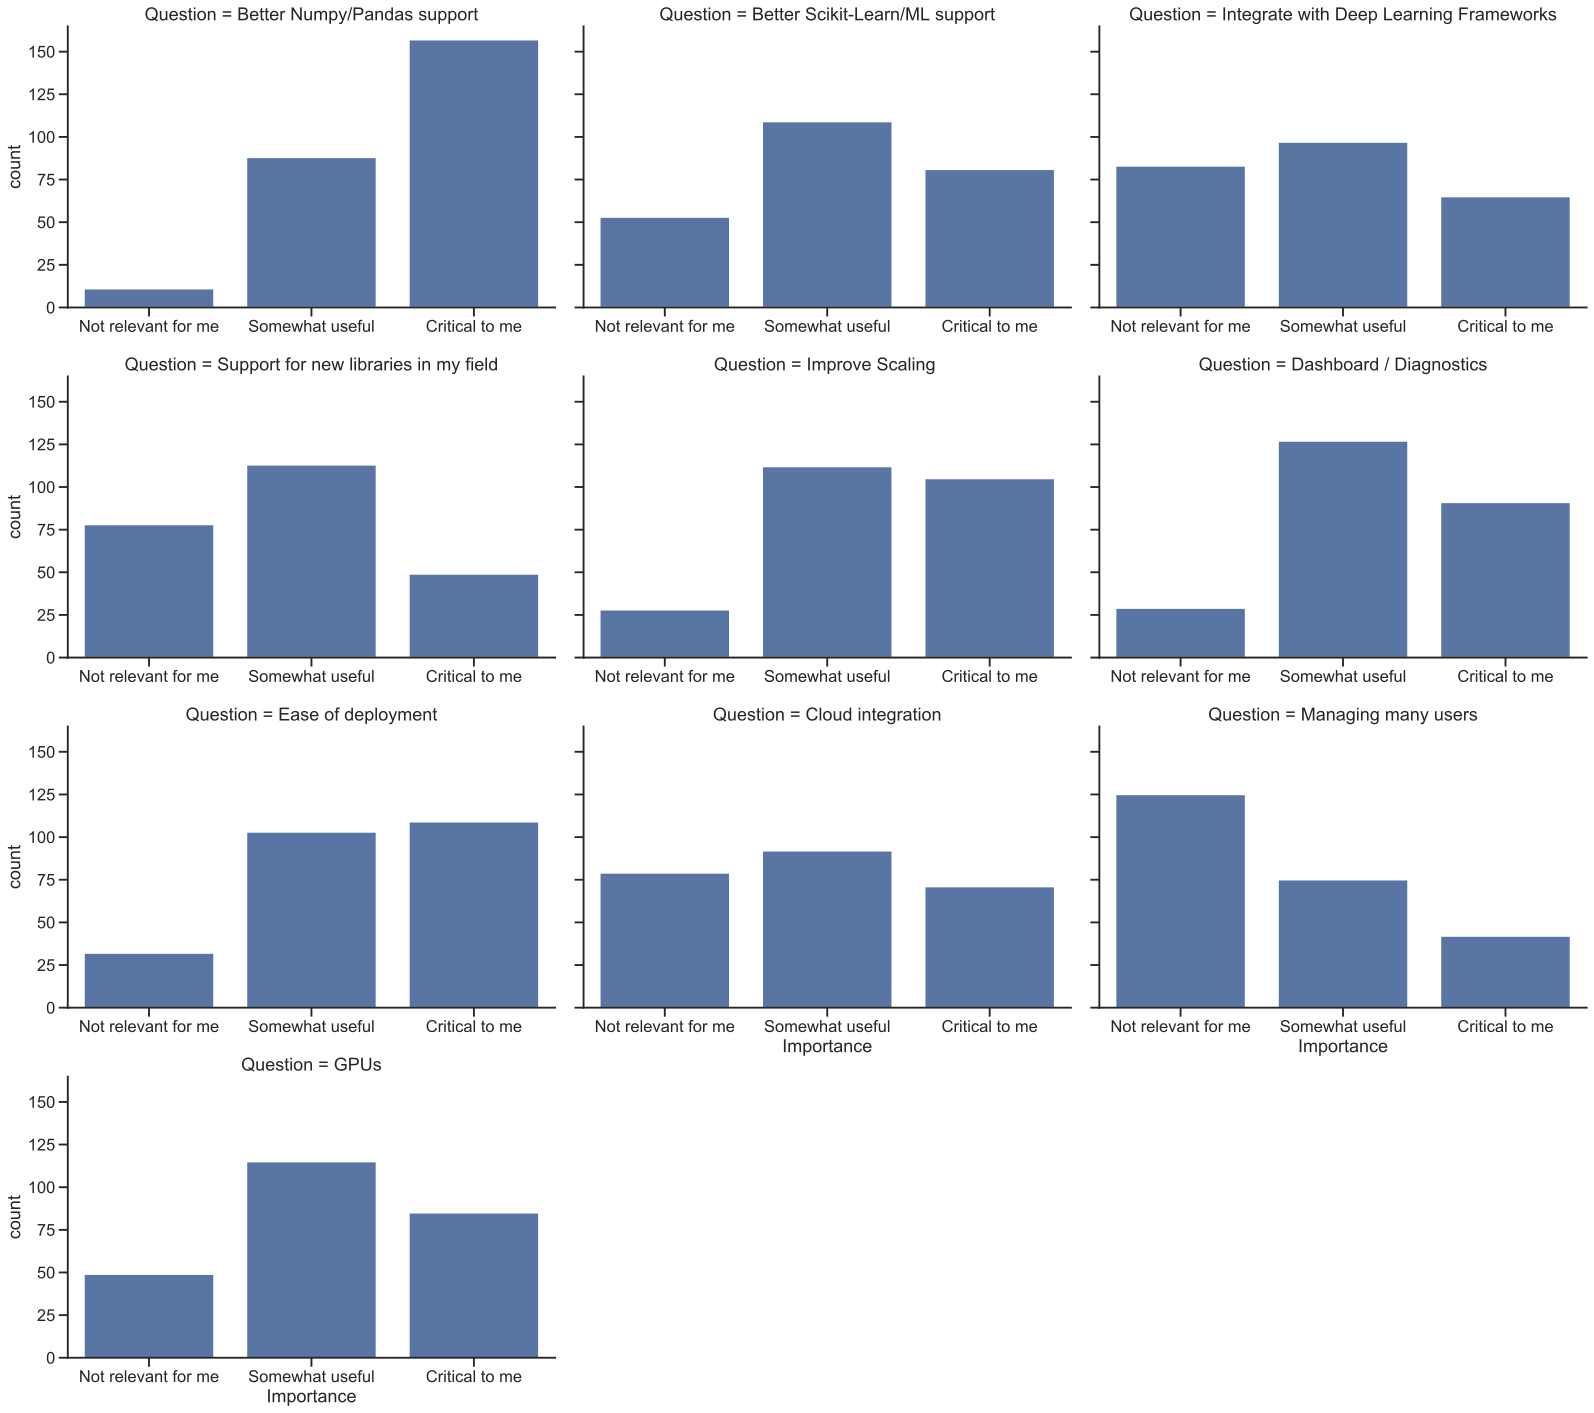

In [44]:
counts = (
    common.apply(pd.value_counts)
    .T.stack().reset_index()
    .rename(columns={'level_0': 'Question', 'level_1': "Importance", 0: "count"})
)

order = ["Not relevant for me", "Somewhat useful", 'Critical to me']
g = (
    sns.FacetGrid(counts, col="Question", col_wrap=3, aspect=1.5, sharex=False, height=5)
    .map(sns.barplot, "Importance", "count", order=order)
)

The clearest standout is how many people thought "Better NumPy/Pandas support" was "most critical". In hindsight, it'd be good to have a followup fill-in field to undertand what each respondent meant by that. The parsimonious interpretion is "cover more of the NumPy / pandas API".

"Ease of deployment" had a high proportion of "critical to me". Again in hindsight, I notice a bit of ambiguity. Does this mean people want Dask to be easier to deploy? Or does this mean that Dask, which they currently find easy to deploy, is critically important? Regardless, we can prioritize simplicity in deployment.

Relatively few respondents care about things like "Managing many users", though we expect that this would be relatively popular among system administartors, who are a smaller population.

And of course, we have people pushing Dask to its limits for whom "Improving scaling" is critically important.

## What other systems do you use?

A relatively high proportion of respondents use Python 3 (97% compared to 84% in the most recent [Python Developers Survey](https://www.jetbrains.com/research/python-developers-survey-2018/)).

In [19]:
df['Python 2 or 3?'].dropna().astype(int).value_counts(normalize=True).apply("{:0.2%}".format)

3    97.29%
2     2.71%
Name: Python 2 or 3?, dtype: object

We were a bit surprised to see that SSH is the most popular "cluster resource manager".

In [20]:
df['If you use a cluster, how do you launch Dask? '].dropna().str.split(";").explode().value_counts().head(6)

SSH                                                       98
Kubernetes                                                73
HPC resource manager (SLURM, PBS, SGE, LSF or similar)    61
My workplace has a custom solution for this               23
I don't know, someone else does this for me               16
Hadoop / Yarn / EMR                                       14
Name: If you use a cluster, how do you launch Dask? , dtype: int64

How does cluster-resource manager compare with API usage?

In [21]:
managers = (
    df['If you use a cluster, how do you launch Dask? '].str.split(";").explode().dropna()
        .replace(re.compile("HPC.*"), "HPC")
    .loc[lambda x: x.isin(cluster_manager_choices)]
)

apis = (
    df['Dask APIs'].str.split(";").explode().dropna()
    .loc[lambda x: x.isin(api_choices)]
)
wm = pd.merge(apis, managers, left_index=True, right_index=True).replace("My workplace has a custom solution for this", "Custom")

x = wm.groupby("Dask APIs")["If you use a cluster, how do you launch Dask? "].value_counts().unstack().T
x.style.background_gradient(axis="columns")

Dask APIs,Array,Bag,DataFrame,Delayed,Futures,ML,Xarray
"If you use a cluster, how do you launch Dask?",,,,,,,
Custom,15,6,18,17,14,6,7
HPC,50,13,40,40,22,11,30
Hadoop / Yarn / EMR,7,6,12,8,4,7,3
Kubernetes,40,18,56,47,37,26,21
SSH,61,23,72,58,32,30,25


HPC users are relatively heavy users of `dask.array` and xarray.

Somewhat surprisingly, Dask's heaviest users find dask stable enough. Perhaps they've pushed past the bugs and found workarounds (percentages are normalized by row).

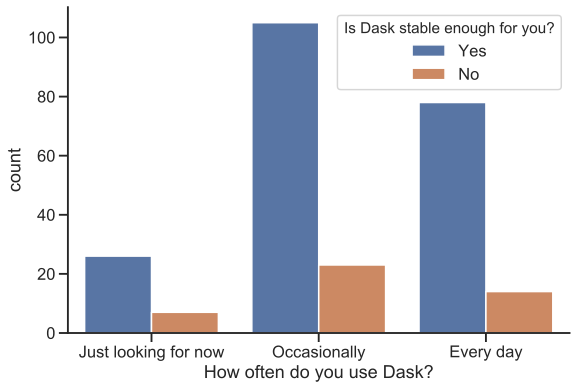

In [22]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.countplot(x="How often do you use Dask?", hue="Is Dask stable enough for you?", data=df, ax=ax,
              order=reversed(usage_order));
sns.despine()

## Takeaways

1. We should prioritize improving and expanding our documentation and examples. This may be
   accomplished by Dask maintainers seeking examples from the community. Many of the examples
   on https://examples.dask.org were developed by domain specialist who use Dask.
2. Improved scaling to larger problems is important, but we shouldn't
   sacrifice the single-machine usecase to get there.
3. Both interactive and batch workflows are important.
4. Dask's various sub-communities are more similar than they are different.

Thanks again to all the respondents. We look forward to repeating this process to identify trends over time.